In [1]:
import os
import numpy as np
import pandas as pd
#caracterísicas de audio y ML. Spicy & audio
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
import librosa
import librosa.display
from IPython.display import Audio
from IPython.display import Image

In [3]:

import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [4]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel, tonnetz, contrast, tempo):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        #sample_rate, audio = wavfile.read(audioPath)
        if tonnetz:
            stft=np.abs(librosa.stft(X)) #short time fournier transform
            result=np.array([])
        if mfcc:
            mfccs=librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
            mfccs_std=np.std(mfccs.T, axis=0)
            mfccs_mean=np.mean(mfccs.T, axis=0)
            result=np.hstack((result, mfccs_mean))
            result=np.hstack((result, mfccs_std))
        if chroma:
            chroma=librosa.feature.chroma_stft(S=stft, sr=sample_rate)
            chroma_mean = np.mean(chroma.T,axis=0)
            chroma_std=np.std(chroma.T,axis=0)
            result=np.hstack((result, chroma_mean))
            result=np.hstack((result, chroma_std))
        if tonnetz:
            y = librosa.effects.harmonic(X)
            tonnetz = librosa.feature.tonnetz(y=y, sr=sample_rate)
            tonnetz_mean = np.mean(tonnetz.T,axis=0)
            tonnetz_std = np.std(tonnetz.T,axis=0)
            result=np.hstack((result, tonnetz_mean))
            result=np.hstack((result, tonnetz_std))
        if contrast:
            contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
            contrast_mean = np.mean(contrast.T,axis=0)
            contrast_std = np.std(contrast.T,axis=0)
            result=np.hstack((result, contrast_mean))
            result=np.hstack((result, contrast_std))
        if tempo:
            tempo=librosa.feature.tempogram(X, sr=sample_rate)
            tempo_mean=np.mean(tempo.T,axis=0)
            tempo_std=np.std(tempo.T,axis=0)
            result=np.hstack((result, tempo_mean))
            result=np.hstack((result, tempo_std))
        return result

In [5]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised' 
}
#DataFlair - Emotions to observe TODO
observed_emotions=['neutral', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
#observed_emotions=['sample', 'surprised']
#observed_emotions=['happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [7]:
df = pd.DataFrame(columns=['feature'])
def load_data_save(test_size=0.25): #parámetro de entrada: tamaño relativo del conjunto de pruebas.
    x,y=[],[]
    bookmark=0
    for file in glob.glob("C:\\audio_emotions_ddbb\\Emotions\\*\\*.wav"):
        #file_name=os.path.basename(file)
        emotion_path = os.path.dirname(file)
        emotion_code = emotion_path[32:34]
        emotion=emotions[emotion_code]
        print(file)
        
        if emotion not in observed_emotions:
            continue
        
        #!!!!cuidado controlar estado. read about it caracteristicas sonido emocion:
        feature=extract_feature(file, mfcc=True, chroma=False, mel=False, tonnetz=True, contrast=True, tempo=False)
        
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1 
        
        x.append(feature)
        y.append(emotion)
        
    
    #return train_test_split(np.array(x), y, test_size=test_size, random_state=23) #primer ejemplo básico
    return x,y

In [ ]:
x,y=load_data_save()

In [9]:
labels = pd.DataFrame(y)

In [10]:
labels

,0
0,neutral
1,neutral
2,neutral
3,neutral
4,neutral
...,...
12789,surprised
12790,surprised
12791,surprised
12792,surprised


In [11]:
df[:5]

,feature
0,"[-675.8519287109375, 68.95927429199219, -4.962..."
1,"[-650.8194580078125, 75.0591049194336, -1.5584..."
2,"[-718.5986938476562, 60.43170928955078, -7.502..."
3,"[-745.6256713867188, 79.43790435791016, 11.096..."
4,"[-767.4625854492188, 73.54008483886719, -14.75..."


In [12]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [13]:
newdf = pd.concat([df3,labels], axis=1)

In [14]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [15]:
rnewdf[5:]

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,0
5,-685.116638,91.437202,6.689507,19.391891,8.057633,17.248400,-7.020536,2.327567,-8.877208,-1.717042,...,15.897645,19.014355,7.592502,4.929736,5.647675,4.584791,4.754142,3.427352,5.028133,neutral
6,-724.681519,78.935860,8.528006,21.338789,9.212902,15.382848,-6.691697,14.009059,-6.308383,-2.718124,...,16.264015,18.960651,5.001796,6.135749,6.267520,4.634555,4.879676,4.469257,6.315724,neutral
7,-772.303162,100.141235,22.751472,28.350561,20.882336,24.289949,5.614294,8.056146,4.342381,4.477574,...,15.150630,16.314564,7.159265,3.395386,4.265461,3.941431,4.196633,3.839288,3.706591,neutral
8,-596.937866,64.640549,6.658104,8.087179,-0.222232,11.440670,-8.109156,0.893835,-8.189038,-3.269589,...,17.244242,20.485955,7.133267,6.536438,6.635699,5.425050,5.157412,4.342479,7.107570,neutral
9,-758.873962,71.857773,19.127047,27.317024,8.173655,17.783045,1.273392,9.496479,3.150365,2.682944,...,15.153395,17.463745,5.691913,4.006061,5.162473,3.769115,3.918807,3.001955,5.210254,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12789,-373.571198,36.366299,-2.157369,6.821621,-16.811443,-12.292907,-8.831902,-7.274284,-14.318125,6.057592,...,20.569154,18.644664,3.926660,6.775583,7.481976,6.841064,6.332471,5.676910,3.011434,surprised
12790,-353.346008,54.927082,-12.304865,-2.287454,-7.903244,-6.621087,-6.898938,-22.647326,-14.456879,8.343707,...,22.237967,18.167703,4.704563,7.426226,7.033934,7.485014,7.329936,5.720448,2.769104,surprised
12791,-345.018524,37.398735,7.392716,-1.535778,-3.167645,-1.351774,-9.390779,-3.230875,-10.671540,5.572508,...,19.363018,18.608207,5.217429,7.461567,7.935539,7.344605,6.616200,4.716760,2.968558,surprised
12792,-339.578461,42.287437,-21.787771,-1.235694,-19.673302,-13.760871,-2.860287,-17.900232,-10.700090,8.645143,...,21.949074,17.513468,4.426247,7.410437,7.717759,7.825015,5.491162,5.285593,2.228130,surprised


In [16]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,0
1273,-392.783264,94.328911,45.283234,12.352729,12.771209,8.829780,0.881616,-3.247745,6.219347,-2.157610,...,17.073937,16.186527,4.544324,3.098545,4.225371,4.619189,3.452769,2.546661,2.320199,neutral
8415,-368.625763,77.353737,-24.071175,6.486173,-6.973119,7.145636,-7.177420,-0.686478,-19.632343,-9.927965,...,18.536908,28.837100,5.339986,6.061968,6.101353,4.607226,3.934175,3.428963,7.697190,fearful
8367,-577.497375,83.882271,-8.494056,9.778959,3.207312,11.159601,-4.180042,-4.737381,-13.775958,-6.839617,...,16.745386,20.781756,8.672141,4.967111,5.051483,4.149473,4.269341,3.414721,6.430565,fearful
4801,-402.469086,103.841675,46.083050,34.582401,11.092615,2.176936,-4.273574,-6.196806,2.955269,-2.183019,...,15.332977,14.385252,4.518117,3.430015,3.981652,2.801457,2.351993,2.980572,2.070949,sad
10891,-314.991577,75.039787,42.037598,29.151686,11.224080,2.822033,-6.794824,-7.020566,-5.739943,-2.909418,...,16.923636,15.100742,5.985700,4.569044,4.488438,3.008284,3.063932,2.764615,1.738414,disgust
8666,-501.178070,51.940449,-27.606472,8.242410,-16.467056,2.101867,-19.569218,-7.978705,-10.363755,-12.394136,...,18.296028,25.074117,4.213242,9.369466,9.650951,7.049573,6.583560,5.273841,8.546760,fearful
2188,-338.716003,89.372032,6.808161,19.434217,13.302464,-1.298847,-8.151358,-1.161327,-1.677142,-12.018962,...,17.644678,15.073741,4.306770,4.731978,4.771043,4.698865,3.836142,2.844359,2.333613,happy
11630,-366.473724,116.473503,34.275791,24.570807,-4.703010,-0.388512,2.057467,-8.678393,-3.181985,2.415591,...,17.218716,15.015137,4.010038,3.695529,4.663007,5.112412,3.348628,4.294433,2.057778,disgust
7556,-347.395905,99.449257,34.083130,23.719446,-3.754120,-1.486884,0.719823,-3.739730,-4.952809,-1.159766,...,16.743163,14.991671,4.818145,3.600152,5.331615,3.892394,3.857519,4.250549,2.025978,angry
11606,-361.338287,102.296280,41.344173,25.607288,2.293870,3.135016,-3.084828,-3.975973,-2.589830,1.024479,...,16.235363,14.743049,4.092959,4.557640,3.943955,3.438913,2.861558,3.058457,2.089002,disgust


In [17]:
rnewdf=rnewdf.fillna(0)

In [18]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [19]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,0
5122,-389.816284,106.497673,37.764675,26.321276,9.681936,6.507189,1.204961,-5.580924,-0.012629,-2.534966,...,15.933673,13.736297,4.242336,3.583771,3.791383,2.663103,2.944422,2.940811,1.678927,sad
11363,-379.691956,110.043808,33.128582,18.779902,11.347034,6.679588,4.176118,-7.900110,2.252837,3.171189,...,15.938093,14.212116,4.529468,3.243237,4.579487,3.435019,2.930982,1.728742,1.717561,disgust
11749,-458.203186,119.912285,49.853245,19.350389,15.654091,10.713547,2.243114,2.154833,-0.864454,-5.589800,...,15.541329,15.545661,4.572756,4.078416,3.418702,3.590886,2.595761,1.621602,2.355618,disgust
12733,-382.231781,64.148094,-3.204594,-5.535476,-14.163459,-5.728434,-2.664003,-17.756250,-16.625057,2.387888,...,20.932713,17.772539,3.457989,7.527640,7.520716,6.809297,6.353376,5.032585,3.220885,surprised
6212,-571.903503,41.116348,-11.141850,1.752401,-8.361308,-5.094497,-17.753567,1.902502,-14.487945,-7.720416,...,16.858158,22.088770,5.288824,6.635863,6.997214,5.291487,5.438424,4.728639,7.986164,angry
5976,-408.298920,62.543106,34.393379,42.787781,0.544979,5.555567,1.450972,-15.038568,1.909269,-5.733157,...,19.834974,16.681727,6.954148,9.689950,8.077956,7.099840,5.526892,3.966555,2.498043,sad
10313,-323.908844,30.386103,-15.620962,12.766439,-1.647030,-4.902674,4.289883,-8.452417,-10.366318,12.228971,...,23.481450,18.676576,3.734209,9.534414,9.310305,7.434817,6.457063,5.709255,3.562252,fearful
8375,-626.842163,66.127060,8.608271,18.644911,0.655160,12.814801,-0.856079,6.609430,-2.484704,-2.651491,...,15.719750,19.735882,6.637293,4.740114,5.223476,4.989841,4.100201,3.298387,7.131989,fearful
3591,-447.762909,71.156517,13.152398,3.165583,6.454585,-1.875900,-14.387619,-3.734907,-6.909373,-10.881612,...,18.905708,16.552403,4.932189,8.709632,8.369645,6.333584,5.120998,2.819691,2.179769,happy
3566,-459.100311,95.514877,25.627977,-14.468506,-6.057425,-0.726688,-12.357471,-2.812884,-11.629498,-5.872456,...,18.474315,16.320162,5.323954,8.608100,6.747097,6.792226,5.713624,3.007036,2.148636,happy


In [20]:
trainfeatures = train.iloc[:, :-1]

In [21]:
trainlabel = train.iloc[:, -1:]

In [22]:
testfeatures = test.iloc[:, :-1]

In [23]:
testlabel = test.iloc[:, -1:]

In [24]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

C:\Users\amand\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [25]:
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
X_train.shape

(10210, 52)

In [27]:
#changing dimension for LSTM model
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [208]:
from keras.optimizers import RMSprop, Adam
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [45]:
from tensorflow import keras

In [52]:
model = Sequential()
#este es el modelo que funcionó bien
model.add(LSTM(256, input_shape=(52,1)))
model.add(Activation('relu')) #
model.add(Flatten()) #esto es importante para la prección del modelo
model.add(Dense(7))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

In [55]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 256)               264192    
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 1799      
_________________________________________________________________
activation_18 (Activation)   (None, 7)                 0         
Total params: 265,991
Trainable params: 265,991
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [54]:
cnnhistorym=model.fit(x_traincnn, y_train, batch_size=16, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
639/639 [==============================] - 39s 61ms/step - loss: 1.8754 - accuracy: 0.1860 - val_loss: 1.8563 - val_accuracy: 0.1803
Epoch 2/150
639/639 [==============================] - 38s 59ms/step - loss: 1.7936 - accuracy: 0.2494 - val_loss: 1.7699 - val_accuracy: 0.2713
Epoch 3/150
639/639 [==============================] - 37s 58ms/step - loss: 1.7473 - accuracy: 0.2727 - val_loss: 1.7153 - val_accuracy: 0.2856
Epoch 4/150
639/639 [==============================] - 37s 58ms/step - loss: 1.6919 - accuracy: 0.3024 - val_loss: 1.6482 - val_accuracy: 0.3615
Epoch 5/150
639/639 [==============================] - 38s 59ms/step - loss: 1.6004 - accuracy: 0.3612 - val_loss: 1.6598 - val_accuracy: 0.3293
Epoch 6/150
639/639 [==============================] - 38s 59ms/step - loss: 1.5272 - accuracy: 0.3953 - val_loss: 1.7330 - val_accuracy: 0.3131
Epoch 7/150
639/639 [==============================] - 38s 60ms/step - loss: 1.4682 - accuracy: 0.4100 - val_loss: 1.4367 - val_ac

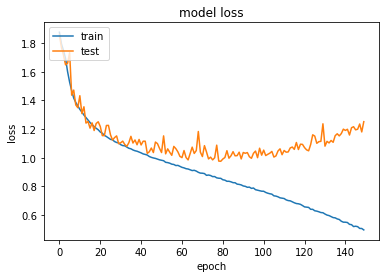

In [57]:
plt.plot(cnnhistorym.history['loss'])
plt.plot(cnnhistorym.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


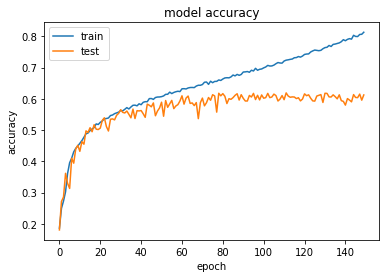

In [59]:
# summarize history for accuracy
plt.plot(cnnhistorym.history['accuracy'])
plt.plot(cnnhistorym.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
 # evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 61.22%


In [62]:

preds = model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

81/81 [==============================] - 3s 42ms/step


In [65]:
preds1=preds.argmax(axis=1)

In [66]:
preds1

array([2, 0, 3, ..., 2, 0, 6], dtype=int64)

In [67]:
abc = preds1.astype(int).flatten()

In [68]:
predictions = (lb.inverse_transform((abc)))

In [69]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,fearful
1,angry
2,happy
3,surprised
4,neutral
5,fearful
6,angry
7,fearful
8,disgust
9,surprised


In [70]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [76]:
actualvalues

array(['fearful', 'fearful', 'happy', ..., 'fearful', 'angry',
       'surprised'], dtype=object)

In [71]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,fearful
1,fearful
2,happy
3,surprised
4,neutral
5,fearful
6,angry
7,fearful
8,disgust
9,surprised


In [72]:
finaldf = actualdf.join(preddf)

In [73]:
finaldf

,actualvalues,predictedvalues
0,fearful,fearful
1,fearful,angry
2,happy,happy
3,surprised,surprised
4,neutral,neutral
...,...,...
2579,sad,neutral
2580,neutral,happy
2581,fearful,fearful
2582,angry,angry


In [74]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,460
disgust,368
fearful,407
happy,444
neutral,370
sad,410
surprised,125


In [75]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,435
disgust,333
fearful,279
happy,502
neutral,477
sad,434
surprised,124


In [61]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y,labels=observed_emotions)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=observed_emotions, yticklabels=observed_emotions, annot=True, fmt="d");
    #sns.heatmap(conf_matrix);
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

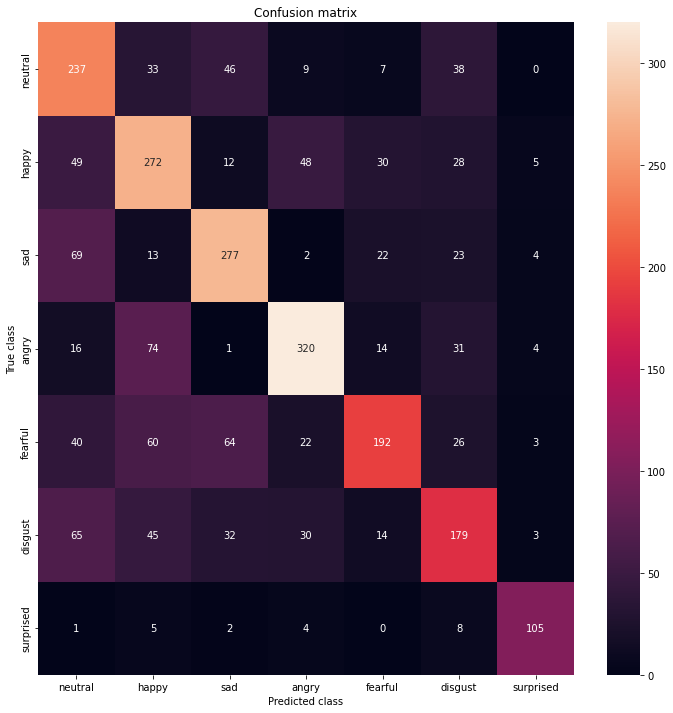

              precision    recall  f1-score   support

       angry       0.74      0.70      0.72       460
     disgust       0.54      0.49      0.51       368
     fearful       0.69      0.47      0.56       407
       happy       0.54      0.61      0.58       444
     neutral       0.50      0.64      0.56       370
         sad       0.64      0.68      0.66       410
   surprised       0.85      0.84      0.84       125

    accuracy                           0.61      2584
   macro avg       0.64      0.63      0.63      2584
weighted avg       0.62      0.61      0.61      2584



In [77]:
mostrar_resultados(actualvalues, preddf)

## Segundo intento de LSTM

In [82]:
model_b = Sequential()
#este es el modelo que funcionó bien
model_b.add(LSTM(128, input_shape=(52,1)))
#model_b.add(LSTM(52))
model_b.add(Dropout(0.1))
#model_b.add(Activation('relu')) #
#model_b.add(Flatten()) #esto es importante para la prección del modelo
model_b.add(Dense(7))
model_b.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

In [84]:
model_b.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [86]:
cnnhistorym_b=model_b.fit(x_traincnn, y_train, batch_size=256, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
40/40 [==============================] - 16s 404ms/step - loss: 1.8756 - accuracy: 0.1852 - val_loss: 1.8586 - val_accuracy: 0.1711
Epoch 2/150
40/40 [==============================] - 16s 401ms/step - loss: 1.8729 - accuracy: 0.1845 - val_loss: 1.8578 - val_accuracy: 0.1726
Epoch 3/150
40/40 [==============================] - 16s 399ms/step - loss: 1.8674 - accuracy: 0.1876 - val_loss: 1.8553 - val_accuracy: 0.1892
Epoch 4/150
40/40 [==============================] - 16s 400ms/step - loss: 1.8670 - accuracy: 0.1924 - val_loss: 1.8559 - val_accuracy: 0.1695
Epoch 5/150
40/40 [==============================] - 16s 398ms/step - loss: 1.8679 - accuracy: 0.1839 - val_loss: 1.8540 - val_accuracy: 0.1730
Epoch 6/150
40/40 [==============================] - 16s 399ms/step - loss: 1.8663 - accuracy: 0.1864 - val_loss: 1.8549 - val_accuracy: 0.1707
Epoch 7/150
40/40 [==============================] - 16s 397ms/step - loss: 1.8664 - accuracy: 0.1801 - val_loss: 1.8530 - val_accuracy:

In [ ]:
#Segundo entrenamiento
cnnhistorym_b=model_b.fit(x_traincnn, y_train, batch_size=256, epochs=150, validation_data=(x_testcnn, y_test))

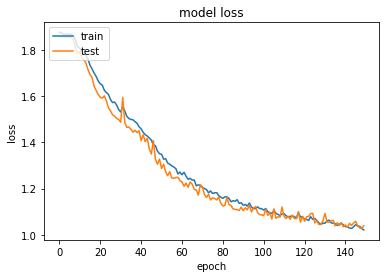

In [88]:
plt.plot(cnnhistorym_b.history['loss'])
plt.plot(cnnhistorym_b.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


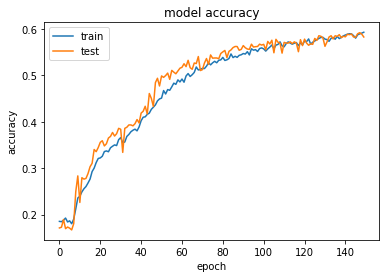

In [89]:
# summarize history for accuracy
plt.plot(cnnhistorym_b.history['accuracy'])
plt.plot(cnnhistorym_b.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [91]:
model_c = Sequential()
#este es el modelo que funcionó bien
model_c.add(LSTM(256, input_shape=(52,1)))
#model_b.add(LSTM(52))
model_c.add(Dropout(0.1))
#model_b.add(Activation('relu')) #
#model_b.add(Flatten()) #esto es importante para la prección del modelo
model_c.add(Dense(7))
model_c.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

In [92]:
model_c.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [96]:
cnnhistorym_c=model_c.fit(x_traincnn, y_train, batch_size=256, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
40/40 [==============================] - 15s 383ms/step - loss: 0.9161 - accuracy: 0.6329 - val_loss: 1.0131 - val_accuracy: 0.5956
Epoch 2/150
40/40 [==============================] - 15s 365ms/step - loss: 0.9086 - accuracy: 0.6373 - val_loss: 1.0150 - val_accuracy: 0.5925
Epoch 3/150
40/40 [==============================] - 16s 388ms/step - loss: 0.9094 - accuracy: 0.6357 - val_loss: 1.0199 - val_accuracy: 0.5967
Epoch 4/150
40/40 [==============================] - 14s 362ms/step - loss: 0.9125 - accuracy: 0.6350 - val_loss: 1.0100 - val_accuracy: 0.5971
Epoch 5/150
40/40 [==============================] - 14s 360ms/step - loss: 0.9157 - accuracy: 0.6294 - val_loss: 1.0211 - val_accuracy: 0.5933
Epoch 6/150
40/40 [==============================] - 14s 358ms/step - loss: 0.9075 - accuracy: 0.6356 - val_loss: 1.0178 - val_accuracy: 0.6022
Epoch 7/150
40/40 [==============================] - 14s 360ms/step - loss: 0.9043 - accuracy: 0.6409 - val_loss: 1.0084 - val_accuracy:

KeyboardInterrupt: 

In [97]:
 # evaluate loaded model on test data
model_c.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score_c = model_c.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model_c.metrics_names[1], score_c[1]*100))

accuracy: 59.09%


## Red LSTM intento c

In [140]:
model_lstmc = Sequential()
model_lstmc.add(LSTM(256, input_shape=(52,1)))
model_lstmc.add(Activation('relu'))
model_lstmc.add(Dropout(0.1))
model_lstmc.add(Flatten()) #esto es importante para la prección del modelo
model_lstmc.add(Dense(7))
model_lstmc.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

In [141]:
model_lstmc.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [142]:
cnnhistory_lstmc=model_lstmc.fit(x_traincnn, y_train, batch_size=256, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
40/40 [==============================] - 22s 551ms/step - loss: 1.9142 - accuracy: 0.1701 - val_loss: 1.8880 - val_accuracy: 0.1788
Epoch 2/200
40/40 [==============================] - 20s 500ms/step - loss: 1.8855 - accuracy: 0.1860 - val_loss: 1.8796 - val_accuracy: 0.1958
Epoch 3/200
40/40 [==============================] - 20s 490ms/step - loss: 1.8773 - accuracy: 0.1891 - val_loss: 1.8728 - val_accuracy: 0.1896
Epoch 4/200
40/40 [==============================] - 19s 466ms/step - loss: 1.8690 - accuracy: 0.1992 - val_loss: 1.8627 - val_accuracy: 0.1676
Epoch 5/200
40/40 [==============================] - 19s 478ms/step - loss: 1.8506 - accuracy: 0.2071 - val_loss: 1.8304 - val_accuracy: 0.2550
Epoch 6/200
40/40 [==============================] - 18s 438ms/step - loss: 1.8171 - accuracy: 0.2444 - val_loss: 1.7983 - val_accuracy: 0.2171
Epoch 7/200
40/40 [==============================] - 14s 346ms/step - loss: 1.7883 - accuracy: 0.2568 - val_loss: 1.7821 - val_accuracy:

## LSTM INTENTO D

In [156]:
model_lstmd = Sequential()
model_lstmd.add(LSTM(256, input_shape=(52,1)))
model_lstmd.add(Activation('relu'))
model_lstmd.add(LSTM(256),)
model_lstmd.add(Activation('relu'))
model_lstmd.add(LSTM(256))
model_lstmd.add(Activation('relu'))
model_lstmd.add(Dropout(0.1))
model_lstmd.add(Flatten()) #esto es importante para la prección del modelo
model_lstmd.add(Dense(7))
model_lstmd.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-8)

ValueError: Input 0 of layer lstm_28 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 256]

In [ ]:
model_lstmd.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
cnnhistory_lstmd=model_lstmd.fit(x_traincnn, y_train, batch_size=256, epochs=200, validation_data=(x_testcnn, y_test))

## Red Convolucional

In [106]:
model_cnn = Sequential()

model_cnn.add(Conv1D(128, 5,padding='same', input_shape=(52,1)))
model_cnn.add(Activation('relu'))
model_cnn.add(Conv1D(128, 5,padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.1))
model_cnn.add(MaxPooling1D(pool_size=(8)))
model_cnn.add(Conv1D(128, 5,padding='same',))
model_cnn.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model_cnn.add(Conv1D(128, 5,padding='same',))
model_cnn.add(Activation('relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(7))
model_cnn.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [107]:
model_cnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 52, 128)           768       
_________________________________________________________________
activation_31 (Activation)   (None, 52, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 52, 128)           82048     
_________________________________________________________________
activation_32 (Activation)   (None, 52, 128)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 52, 128)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 6, 128)          

In [108]:
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [109]:
cnnhistory_cnn=model_cnn.fit(x_traincnn, y_train, batch_size=256, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/100
40/40 [==============================] - 5s 114ms/step - loss: 2.7503 - accuracy: 0.1633 - val_loss: 1.8454 - val_accuracy: 0.2771
Epoch 2/100
40/40 [==============================] - 4s 105ms/step - loss: 1.8802 - accuracy: 0.2527 - val_loss: 1.6983 - val_accuracy: 0.3154
Epoch 3/100
40/40 [==============================] - 4s 96ms/step - loss: 1.7655 - accuracy: 0.2973 - val_loss: 1.6326 - val_accuracy: 0.3467
Epoch 4/100
40/40 [==============================] - 4s 93ms/step - loss: 1.7137 - accuracy: 0.3122 - val_loss: 1.6101 - val_accuracy: 0.3495
Epoch 5/100
40/40 [==============================] - 4s 92ms/step - loss: 1.6816 - accuracy: 0.3274 - val_loss: 1.5869 - val_accuracy: 0.3793
Epoch 6/100
40/40 [==============================] - 4s 93ms/step - loss: 1.6510 - accuracy: 0.3342 - val_loss: 1.5621 - val_accuracy: 0.3831
Epoch 7/100
40/40 [==============================] - 4s 96ms/step - loss: 1.6316 - accuracy: 0.3491 - val_loss: 1.5511 - val_accuracy: 0.3971
Epoc

In [ ]:
# summarize history for accuracy
plt.plot(cnnhistory_cnn.history['accuracy'])
plt.plot(cnnhistory_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Convolucional 2 ejemplo basico

In [122]:
model_cnn2 = Sequential()
model_cnn2.add(Conv1D(256, 5,padding='same', input_shape=(52,1)))
model_cnn2.add(Activation('relu'))
model_cnn2.add(Dropout(0.1))
model_cnn2.add(Flatten()) #esto es importante para la prección del modelo
model_cnn2.add(Dense(7))
model_cnn2.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

In [123]:
model_cnn2.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [124]:
cnnhistory_cnn2=model_cnn2.fit(x_traincnn, y_train, batch_size=256, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
40/40 [==============================] - 2s 61ms/step - loss: 2.7629 - accuracy: 0.2124 - val_loss: 1.5823 - val_accuracy: 0.3646
Epoch 2/200
40/40 [==============================] - 2s 58ms/step - loss: 2.2315 - accuracy: 0.2781 - val_loss: 1.5046 - val_accuracy: 0.4017
Epoch 3/200
40/40 [==============================] - 2s 57ms/step - loss: 2.0957 - accuracy: 0.3099 - val_loss: 1.4946 - val_accuracy: 0.4315
Epoch 4/200
40/40 [==============================] - 2s 58ms/step - loss: 2.0179 - accuracy: 0.3389 - val_loss: 1.3895 - val_accuracy: 0.4934
Epoch 5/200
40/40 [==============================] - 2s 58ms/step - loss: 1.9353 - accuracy: 0.3452 - val_loss: 1.3467 - val_accuracy: 0.5008
Epoch 6/200
40/40 [==============================] - 2s 60ms/step - loss: 1.8564 - accuracy: 0.3753 - val_loss: 1.3017 - val_accuracy: 0.5197
Epoch 7/200
40/40 [==============================] - 3s 66ms/step - loss: 1.8213 - accuracy: 0.3801 - val_loss: 1.2929 - val_accuracy: 0.5302
Epoch 

In [126]:
model_cnn2.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 52, 256)           1536      
_________________________________________________________________
activation_45 (Activation)   (None, 52, 256)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 52, 256)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 13312)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 7)                 93191     
_________________________________________________________________
activation_46 (Activation)   (None, 7)                 0         
Total params: 94,727
Trainable params: 94,727
Non-trainable params: 0
_________________________________________________

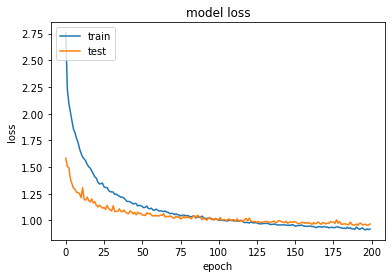

In [127]:
plt.plot(cnnhistory_cnn2.history['loss'])
plt.plot(cnnhistory_cnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


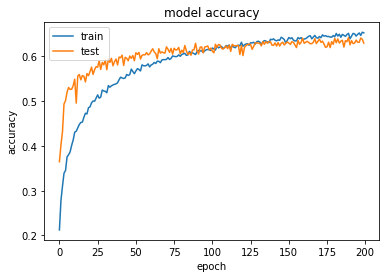

In [128]:
# summarize history for accuracy
plt.plot(cnnhistory_cnn2.history['accuracy'])
plt.plot(cnnhistory_cnn2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [129]:
 # evaluate loaded model on test data
model_cnn2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score_cnn2 = model_cnn2.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model_cnn2.metrics_names[1], score_cnn2[1]*100))

accuracy: 62.93%


In [130]:
preds_cnn2 = model_cnn2.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

81/81 [==============================] - 0s 2ms/step


In [131]:
preds1_cnn2=preds_cnn2.argmax(axis=1)

In [132]:
abc_cnn2 = preds1_cnn2.astype(int).flatten()

In [133]:
predictions_cnn2 = (lb.inverse_transform((abc_cnn2)))

In [134]:
preddf_cnn2 = pd.DataFrame({'predictedvalues': predictions_cnn2})
preddf_cnn2[:10]

,predictedvalues
0,fearful
1,fearful
2,fearful
3,surprised
4,sad
5,angry
6,angry
7,fearful
8,neutral
9,surprised


In [135]:
actual_cnn2=y_test.argmax(axis=1)
abc123_cnn2 = actual_cnn2.astype(int).flatten()
actualvalues_cnn2 = (lb.inverse_transform((abc123_cnn2)))

In [136]:
actualdf_cnn2 = pd.DataFrame({'actualvalues': actualvalues_cnn2})
actualdf_cnn2[:10]

,actualvalues
0,fearful
1,fearful
2,happy
3,surprised
4,neutral
5,fearful
6,angry
7,fearful
8,disgust
9,surprised


In [137]:
finaldf_cnn2 = actualdf_cnn2.join(preddf_cnn2)

In [138]:
finaldf_cnn2

,actualvalues,predictedvalues
0,fearful,fearful
1,fearful,fearful
2,happy,fearful
3,surprised,surprised
4,neutral,sad
...,...,...
2579,sad,neutral
2580,neutral,disgust
2581,fearful,fearful
2582,angry,fearful


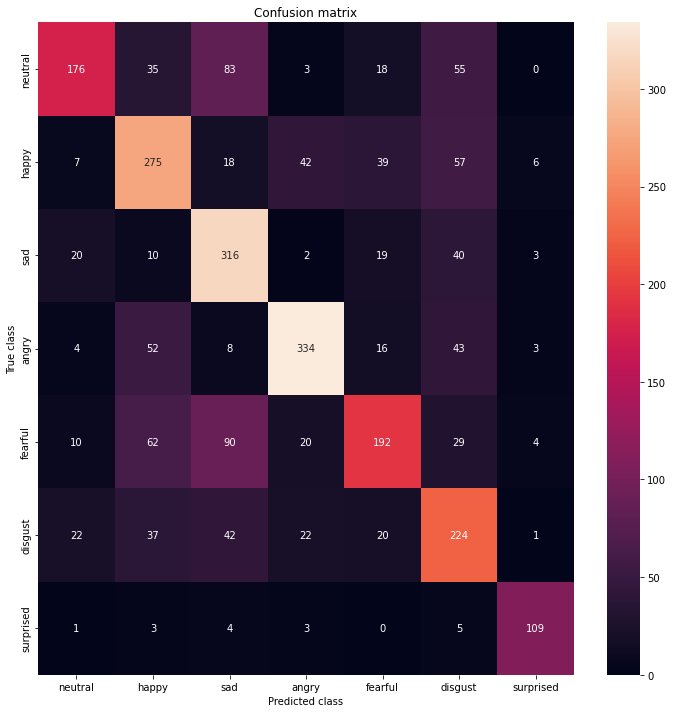

              precision    recall  f1-score   support

       angry       0.78      0.73      0.75       460
     disgust       0.49      0.61      0.55       368
     fearful       0.63      0.47      0.54       407
       happy       0.58      0.62      0.60       444
     neutral       0.73      0.48      0.58       370
         sad       0.56      0.77      0.65       410
   surprised       0.87      0.87      0.87       125

    accuracy                           0.63      2584
   macro avg       0.66      0.65      0.65      2584
weighted avg       0.65      0.63      0.63      2584



In [139]:
mostrar_resultados(actualvalues_cnn2, preddf_cnn2)

In [143]:
## Convolucional 3

In [144]:
cnnhistory_cnn2=model_cnn2.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
639/639 [==============================] - 2s 3ms/step - loss: 1.1000 - accuracy: 0.5923 - val_loss: 1.1069 - val_accuracy: 0.5983
Epoch 2/200
639/639 [==============================] - 2s 3ms/step - loss: 1.0333 - accuracy: 0.6028 - val_loss: 0.9978 - val_accuracy: 0.6192
Epoch 3/200
639/639 [==============================] - 2s 4ms/step - loss: 1.0004 - accuracy: 0.6189 - val_loss: 0.9707 - val_accuracy: 0.6324
Epoch 4/200
639/639 [==============================] - 2s 4ms/step - loss: 0.9876 - accuracy: 0.6195 - val_loss: 1.0462 - val_accuracy: 0.5913
Epoch 5/200
639/639 [==============================] - 2s 3ms/step - loss: 0.9980 - accuracy: 0.6159 - val_loss: 1.0449 - val_accuracy: 0.5937
Epoch 6/200
639/639 [==============================] - 2s 4ms/step - loss: 0.9875 - accuracy: 0.6186 - val_loss: 1.0756 - val_accuracy: 0.5871
Epoch 7/200
639/639 [==============================] - 2s 4ms/step - loss: 0.9861 - accuracy: 0.6186 - val_loss: 1.0685 - val_accuracy: 0.5921

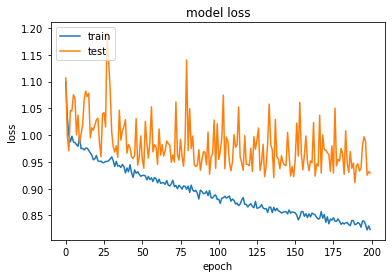

In [145]:
plt.plot(cnnhistory_cnn2.history['loss'])
plt.plot(cnnhistory_cnn2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

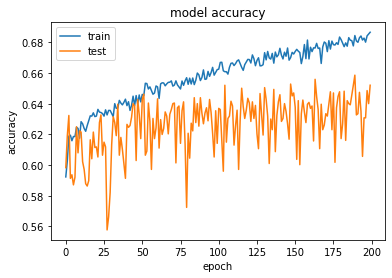

In [146]:
# summarize history for accuracy
plt.plot(cnnhistory_cnn2.history['accuracy'])
plt.plot(cnnhistory_cnn2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## GRU

In [149]:
model_gru = Sequential()
model_gru.add(GRU(256,input_shape=(52,1)))
model_gru.add(Activation('relu'))
model_gru.add(Dropout(0.1))
model_gru.add(Flatten()) #esto es importante para la prección del modelo
model_gru.add(Dense(7))
model_gru.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

In [150]:
model_gru.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [151]:
cnnhistory_gru=model_gru.fit(x_traincnn, y_train, batch_size=256, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
40/40 [==============================] - 17s 430ms/step - loss: 1.9354 - accuracy: 0.1572 - val_loss: 1.9037 - val_accuracy: 0.2020
Epoch 2/200
40/40 [==============================] - 16s 393ms/step - loss: 1.8938 - accuracy: 0.1853 - val_loss: 1.8906 - val_accuracy: 0.1796
Epoch 3/200
40/40 [==============================] - 15s 376ms/step - loss: 1.8843 - accuracy: 0.1990 - val_loss: 1.8811 - val_accuracy: 0.1935
Epoch 4/200
40/40 [==============================] - 14s 351ms/step - loss: 1.8757 - accuracy: 0.1990 - val_loss: 1.8712 - val_accuracy: 0.1958
Epoch 5/200
40/40 [==============================] - 15s 368ms/step - loss: 1.8674 - accuracy: 0.1998 - val_loss: 1.8636 - val_accuracy: 0.1881
Epoch 6/200
40/40 [==============================] - 14s 354ms/step - loss: 1.8587 - accuracy: 0.2013 - val_loss: 1.8549 - val_accuracy: 0.2051
Epoch 7/200
40/40 [==============================] - 13s 337ms/step - loss: 1.8517 - accuracy: 0.1977 - val_loss: 1.8475 - val_accuracy:

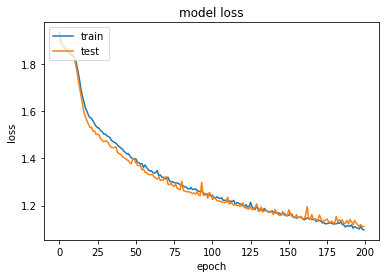

In [152]:
plt.plot(cnnhistory_gru.history['loss'])
plt.plot(cnnhistory_gru.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

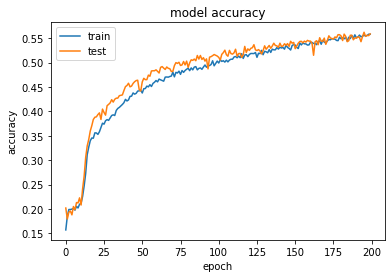

In [153]:
plt.plot(cnnhistory_gru.history['accuracy'])
plt.plot(cnnhistory_gru.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [158]:
cnnhistory_gru_b=model_gru.fit(x_traincnn, y_train, batch_size=256, epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
40/40 [==============================] - 16s 409ms/step - loss: 1.0974 - accuracy: 0.5599 - val_loss: 1.1202 - val_accuracy: 0.5519
Epoch 2/100
40/40 [==============================] - 12s 308ms/step - loss: 1.0985 - accuracy: 0.5623 - val_loss: 1.1197 - val_accuracy: 0.5526
Epoch 3/100
40/40 [==============================] - 12s 312ms/step - loss: 1.0918 - accuracy: 0.5609 - val_loss: 1.1080 - val_accuracy: 0.5580
Epoch 4/100
40/40 [==============================] - 13s 323ms/step - loss: 1.0905 - accuracy: 0.5635 - val_loss: 1.1138 - val_accuracy: 0.5619
Epoch 5/100
40/40 [==============================] - 13s 329ms/step - loss: 1.0925 - accuracy: 0.5623 - val_loss: 1.1070 - val_accuracy: 0.5619
Epoch 6/100
40/40 [==============================] - 12s 312ms/step - loss: 1.0926 - accuracy: 0.5639 - val_loss: 1.1356 - val_accuracy: 0.5495
Epoch 7/100
40/40 [==============================] - 11s 284ms/step - loss: 1.0900 - accuracy: 0.5643 - val_loss: 1.1071 - val_accuracy:

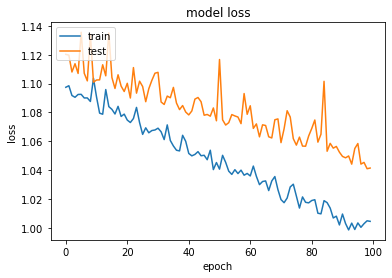

In [159]:
plt.plot(cnnhistory_gru_b.history['loss'])
plt.plot(cnnhistory_gru_b.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

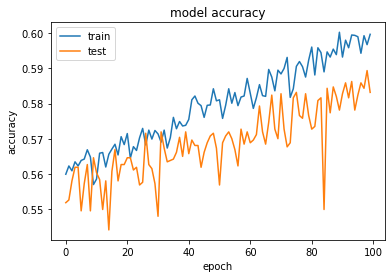

In [160]:
plt.plot(cnnhistory_gru_b.history['accuracy'])
plt.plot(cnnhistory_gru_b.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# RED MIXTA FINAL

In [ ]:
#BASURA

In [175]:
model_mix = Sequential()
model_mix.add(Conv1D(256, 5,padding='same',input_shape=(52,1)))
model_mix.add(Activation('relu'))
model_mix.add(Conv1D(128, 5,padding='same'))
model_mix.add(Activation('relu'))
model_mix.add(Activation('relu'))
model_mix.add(Conv1D(128, 5,padding='same'))
model_mix.add(Dropout(0.1))
model_mix.add(MaxPooling1D(pool_size=(8)))
model_mix.add(LSTM(32))
model_mix.add(Activation('relu'))
model_mix.add(Flatten())
model_mix.add(Dense(7))
model_mix.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.00001, decay=1e-8)

In [177]:
model_mix.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [178]:
cnnhistory_mix=model_mix.fit(x_traincnn, y_train, batch_size=256, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
40/40 [==============================] - 7s 179ms/step - loss: 1.9417 - accuracy: 0.1728 - val_loss: 1.9125 - val_accuracy: 0.2086
Epoch 2/200
40/40 [==============================] - 7s 173ms/step - loss: 1.9017 - accuracy: 0.1821 - val_loss: 1.8912 - val_accuracy: 0.2179
Epoch 3/200
40/40 [==============================] - 8s 195ms/step - loss: 1.8868 - accuracy: 0.1908 - val_loss: 1.8752 - val_accuracy: 0.2086
Epoch 4/200
40/40 [==============================] - 8s 201ms/step - loss: 1.8733 - accuracy: 0.2018 - val_loss: 1.8608 - val_accuracy: 0.2245
Epoch 5/200
40/40 [==============================] - 8s 204ms/step - loss: 1.8620 - accuracy: 0.2095 - val_loss: 1.8505 - val_accuracy: 0.2361
Epoch 6/200
40/40 [==============================] - 8s 202ms/step - loss: 1.8519 - accuracy: 0.2299 - val_loss: 1.8394 - val_accuracy: 0.2434
Epoch 7/200
40/40 [==============================] - 8s 212ms/step - loss: 1.8406 - accuracy: 0.2431 - val_loss: 1.8300 - val_accuracy: 0.2415

KeyboardInterrupt: 

In [ ]:
plt.plot(cnnhistory_mix.history['loss'])
plt.plot(cnnhistory_mix.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(cnnhistory_mix.history['accuracy'])
plt.plot(cnnhistory_mix.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Red Mixta A

In [174]:
#2 conv y 2 lstm
model_mix_a = Sequential()

model_mix_a.add(Conv1D(256, 5,padding='same', input_shape=(52,1)))
model_mix_a.add(Activation('relu'))
model_mix_a.add(Conv1D(128, 5,padding='same'))
model_mix_a.add(Activation('relu'))
model_mix_a.add(Dropout(0.1))
model_mix_a.add(MaxPooling1D(pool_size=(8)))
model_mix_a.add(LSTM(128))
model_mix_a.add(Activation('relu'))
model_mix_a.add(LSTM(128))
model_mix_a.add(Activation('relu'))
model_mix_a.add(Flatten())
model_mix_a.add(Dense(7))
model_mix_a.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

ValueError: Input 0 of layer lstm_33 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 128]

In [ ]:
model_mix_a.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
cnnhistory_mix_a=model_mix_a.fit(x_traincnn, y_train, batch_size=16, epochs=300, validation_data=(x_testcnn, y_test))

# Red mixta C

In [169]:
model_mix_c = Sequential()

model_mix_c.add(Conv1D(256, 5,padding='same', input_shape=(52,1)))
model_mix_c.add(Activation('relu'))
model_mix_c.add(Conv1D(128, 5,padding='same'))
model_mix_c.add(Activation('relu'))
model_mix_c.add(Dropout(0.1))
model_mix_c.add(MaxPooling1D(pool_size=(8)))
model_mix_c.add(Conv1D(128, 5,padding='same',))
model_mix_c.add(Activation('relu'))
model_mix_c.add(Conv1D(128, 5,padding='same',))
model_mix_c.add(Activation('relu'))
model_mix_c.add(Flatten())
model_mix_c.add(Dense(7))
model_mix_c.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

In [263]:
model_mix_c.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 52, 128)           768       
_________________________________________________________________
activation_89 (Activation)   (None, 52, 128)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 52, 256)           164096    
_________________________________________________________________
activation_90 (Activation)   (None, 52, 256)           0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 52, 256)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 52, 256)           327936    
_________________________________________________________________
activation_91 (Activation)   (None, 52, 256)         

In [170]:
model_mix_c.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [171]:
cnnhistory_mix_c=model_mix_c.fit(x_traincnn, y_train, batch_size=16, epochs=300, validation_data=(x_testcnn, y_test))

Epoch 1/300
639/639 [==============================] - 10s 16ms/step - loss: 1.7902 - accuracy: 0.2940 - val_loss: 1.6018 - val_accuracy: 0.3425
Epoch 2/300
639/639 [==============================] - 10s 16ms/step - loss: 1.6133 - accuracy: 0.3525 - val_loss: 1.5182 - val_accuracy: 0.4044
Epoch 3/300
639/639 [==============================] - 10s 16ms/step - loss: 1.5551 - accuracy: 0.3726 - val_loss: 1.4717 - val_accuracy: 0.4180
Epoch 4/300
639/639 [==============================] - 10s 16ms/step - loss: 1.5081 - accuracy: 0.4035 - val_loss: 1.4262 - val_accuracy: 0.4563
Epoch 5/300
639/639 [==============================] - 10s 16ms/step - loss: 1.4768 - accuracy: 0.4181 - val_loss: 1.4083 - val_accuracy: 0.4590
Epoch 6/300
639/639 [==============================] - 10s 16ms/step - loss: 1.4423 - accuracy: 0.4342 - val_loss: 1.3965 - val_accuracy: 0.4586
Epoch 7/300
639/639 [==============================] - 10s 16ms/step - loss: 1.4138 - accuracy: 0.4490 - val_loss: 1.3592 - val_ac

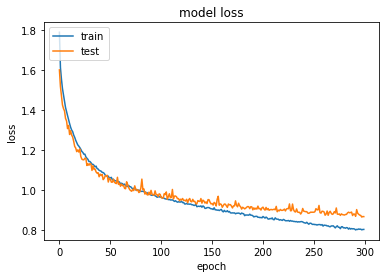

In [172]:
plt.plot(cnnhistory_mix_c.history['loss'])
plt.plot(cnnhistory_mix_c.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

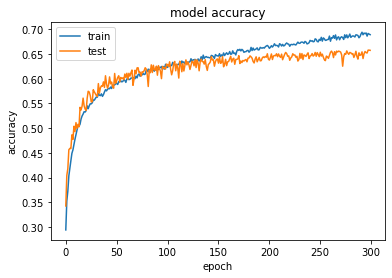

In [173]:
plt.plot(cnnhistory_mix_c.history['accuracy'])
plt.plot(cnnhistory_mix_c.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# (A) TFM MODELO CNN OK

In [ ]:
#prueba con 3 capas

In [264]:
model_3cnn = Sequential()

model_3cnn.add(Conv1D(256, 5,padding='same', input_shape=(52,1)))
model_3cnn.add(Activation('relu'))
model_3cnn.add(Conv1D(128, 5,padding='same'))
model_3cnn.add(Activation('relu'))
model_3cnn.add(Dropout(0.1))
model_3cnn.add(MaxPooling1D(pool_size=(8)))
model_3cnn.add(Conv1D(128, 5,padding='same',))
model_3cnn.add(Activation('relu'))
model_3cnn.add(Flatten())
model_3cnn.add(Dense(7))
model_3cnn.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

In [265]:
model_3cnn.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [266]:
cnnhistory_3cnn=model_3cnn.fit(x_traincnn, y_train, batch_size=16, epochs=250, validation_data=(x_testcnn, y_test))

Epoch 1/250
639/639 [==============================] - 8s 13ms/step - loss: 1.9255 - accuracy: 0.2740 - val_loss: 1.5589 - val_accuracy: 0.3746
Epoch 2/250
639/639 [==============================] - 9s 14ms/step - loss: 1.6345 - accuracy: 0.3376 - val_loss: 1.5203 - val_accuracy: 0.3990
Epoch 3/250
639/639 [==============================] - 9s 14ms/step - loss: 1.5583 - accuracy: 0.3765 - val_loss: 1.4824 - val_accuracy: 0.4060
Epoch 4/250
639/639 [==============================] - 9s 14ms/step - loss: 1.5218 - accuracy: 0.3985 - val_loss: 1.4296 - val_accuracy: 0.4652
Epoch 5/250
639/639 [==============================] - 9s 14ms/step - loss: 1.4823 - accuracy: 0.4213 - val_loss: 1.4139 - val_accuracy: 0.4582
Epoch 6/250
639/639 [==============================] - 8s 13ms/step - loss: 1.4532 - accuracy: 0.4341 - val_loss: 1.3933 - val_accuracy: 0.4706
Epoch 7/250
639/639 [==============================] - 8s 12ms/step - loss: 1.4341 - accuracy: 0.4449 - val_loss: 1.3932 - val_accuracy:

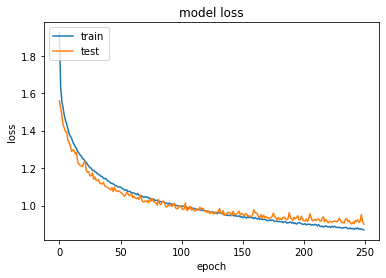

In [267]:
plt.plot(cnnhistory_3cnn.history['loss'])
plt.plot(cnnhistory_3cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

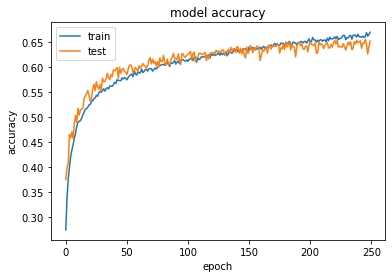

In [268]:
plt.plot(cnnhistory_3cnn.history['accuracy'])
plt.plot(cnnhistory_3cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [269]:
score_3cnn = model_3cnn.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model_3cnn.metrics_names[1], score_3cnn[1]*100))

accuracy: 65.21%


In [270]:
preds_3cnn = model.predict(x_testcnn, batch_size=32, verbose=1)

81/81 [==============================] - 0s 6ms/step


In [271]:
preds1_3cnn=preds_3cnn.argmax(axis=1)

In [272]:
abc_3cnn = preds1_3cnn.astype(int).flatten()

In [273]:
predictions_3cnn = (lb.inverse_transform((abc_3cnn)))

In [278]:
preddf_3cnn = pd.DataFrame({'predictedvalues': predictions_3cnn})
preddf_3cnn[:10]

,predictedvalues
0,surprised
1,surprised
2,surprised
3,surprised
4,sad
5,surprised
6,surprised
7,surprised
8,surprised
9,surprised


In [279]:
actual_3cnn=y_test.argmax(axis=1)
abc123_3cnn = actual_3cnn.astype(int).flatten()
actualvalues_3cnn = (lb.inverse_transform((abc123_3cnn)))

In [281]:
actualdf_3cnn = pd.DataFrame({'actualvalues': actualvalues_3cnn})
actualdf[:10]

,actualvalues
0,fearful
1,fearful
2,happy
3,surprised
4,neutral
5,fearful
6,angry
7,fearful
8,disgust
9,surprised


In [282]:
finaldf_3cnn = actualdf_3cnn.join(preddf_3cnn)

In [283]:
finaldf_3cnn.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,460
disgust,368
fearful,407
happy,444
neutral,370
sad,410
surprised,125


In [284]:
finaldf_3cnn.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
sad,978
surprised,1606


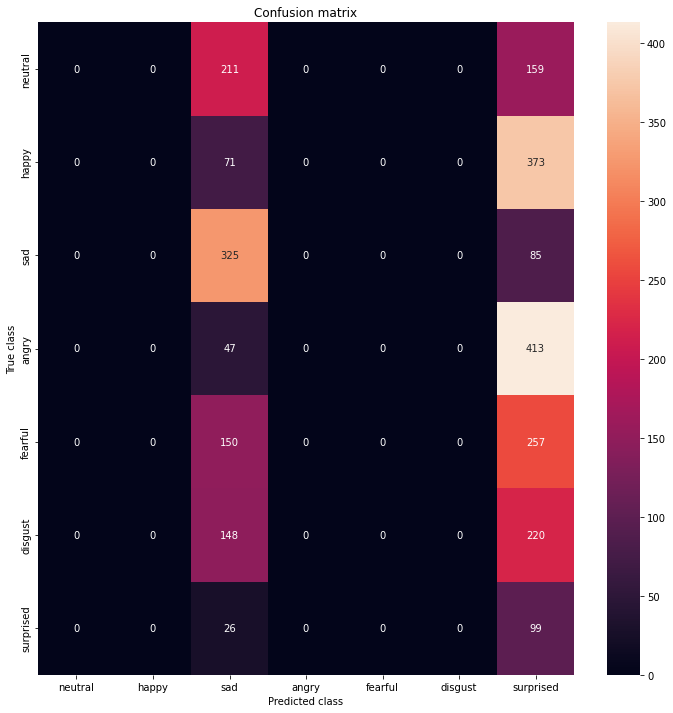

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       460
     disgust       0.00      0.00      0.00       368
     fearful       0.00      0.00      0.00       407
       happy       0.00      0.00      0.00       444
     neutral       0.00      0.00      0.00       370
         sad       0.33      0.79      0.47       410
   surprised       0.06      0.79      0.11       125

    accuracy                           0.16      2584
   macro avg       0.06      0.23      0.08      2584
weighted avg       0.06      0.16      0.08      2584



C:\Users\amand\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amand\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amand\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [287]:
mostrar_resultados(actualvalues_3cnn, preddf_3cnn)

In [ ]:
#2CNN + 1LSTM sustitución conv por lstm

In [275]:
model_cnnlstm = Sequential()

model_cnnlstm.add(Conv1D(256, 5,padding='same', input_shape=(52,1)))
model_cnnlstm.add(Activation('relu'))
model_cnnlstm.add(Conv1D(128, 5,padding='same'))
model_cnnlstm.add(Activation('relu'))
model_cnnlstm.add(Dropout(0.1))
model_cnnlstm.add(MaxPooling1D(pool_size=(8)))
model_cnnlstm.add(LSTM(32))
model_cnnlstm.add(Activation('relu'))
model_cnnlstm.add(Flatten())
model_cnnlstm.add(Dense(7))
model_cnnlstm.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

In [276]:
model_cnnlstm.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [277]:
cnnhistory_cnnlstm=model_cnnlstm.fit(x_traincnn, y_train, batch_size=16, epochs=250, validation_data=(x_testcnn, y_test))

Epoch 1/250
639/639 [==============================] - 9s 14ms/step - loss: 1.9214 - accuracy: 0.1674 - val_loss: 1.9024 - val_accuracy: 0.1718
Epoch 2/250
639/639 [==============================] - 9s 14ms/step - loss: 1.8874 - accuracy: 0.1868 - val_loss: 1.8590 - val_accuracy: 0.2469
Epoch 3/250
639/639 [==============================] - 10s 16ms/step - loss: 1.8486 - accuracy: 0.2650 - val_loss: 1.8238 - val_accuracy: 0.2887
Epoch 4/250
639/639 [==============================] - 10s 16ms/step - loss: 1.8228 - accuracy: 0.2877 - val_loss: 1.8070 - val_accuracy: 0.2887
Epoch 5/250
639/639 [==============================] - 10s 16ms/step - loss: 1.8039 - accuracy: 0.2975 - val_loss: 1.7889 - val_accuracy: 0.2980
Epoch 6/250
639/639 [==============================] - 11s 17ms/step - loss: 1.7900 - accuracy: 0.2964 - val_loss: 1.7711 - val_accuracy: 0.3073
Epoch 7/250
639/639 [==============================] - 10s 16ms/step - loss: 1.7745 - accuracy: 0.3108 - val_loss: 1.7594 - val_accu

KeyboardInterrupt: 

# Red Mixta D

In [ ]:
model_mix_d = Sequential()
model_mix_d.add(Conv1D(256, 5,padding='same', input_shape=(52,1)))
model_mix_d.add(Activation('relu'))
model_mix_d.add(Dropout(0.1))
model_mix_d.add(Flatten()) #esto es importante para la prección del modelo
model_mix.add(MaxPooling1D(pool_size=(8)))
model_mix.add(LSTM(128))
model_mix_d.add(Dense(7))
model_mix_d.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

## Incluir en memoria - TFM 66% 

In [180]:
model_mix_e = Sequential()

model_mix_e.add(Conv1D(128, 5,padding='same', input_shape=(52,1)))
model_mix_e.add(Activation('relu'))
model_mix_e.add(Conv1D(256, 5,padding='same'))
model_mix_e.add(Activation('relu'))
model_mix_e.add(Dropout(0.1))
model_mix_e.add(Conv1D(256, 5,padding='same',))
model_mix_e.add(Activation('relu'))
model_mix_e.add(MaxPooling1D(pool_size=(8)))
model_mix_e.add(LSTM(32))
model_mix_e.add(Activation('relu'))
model_mix_e.add(Flatten())
model_mix_e.add(Dense(7))
model_mix_e.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

In [288]:
model_mix_e.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 52, 128)           768       
_________________________________________________________________
activation_94 (Activation)   (None, 52, 128)           0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 52, 256)           164096    
_________________________________________________________________
activation_95 (Activation)   (None, 52, 256)           0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 52, 256)           0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 52, 256)           327936    
_________________________________________________________________
activation_96 (Activation)   (None, 52, 256)         

In [181]:
model_mix_e.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [182]:
cnnhistory_mix_d=model_mix_e.fit(x_traincnn, y_train, batch_size=16, epochs=300, validation_data=(x_testcnn, y_test))

Epoch 1/300
639/639 [==============================] - 19s 29ms/step - loss: 1.8929 - accuracy: 0.1835 - val_loss: 1.8379 - val_accuracy: 0.2434
Epoch 2/300
639/639 [==============================] - 18s 28ms/step - loss: 1.8273 - accuracy: 0.2644 - val_loss: 1.7837 - val_accuracy: 0.2930
Epoch 3/300
639/639 [==============================] - 20s 32ms/step - loss: 1.7873 - accuracy: 0.2947 - val_loss: 1.7514 - val_accuracy: 0.3293
Epoch 4/300
639/639 [==============================] - 16s 26ms/step - loss: 1.7584 - accuracy: 0.3204 - val_loss: 1.7231 - val_accuracy: 0.3309
Epoch 5/300
639/639 [==============================] - 17s 27ms/step - loss: 1.7366 - accuracy: 0.3264 - val_loss: 1.7021 - val_accuracy: 0.3498
Epoch 6/300
639/639 [==============================] - 16s 26ms/step - loss: 1.7226 - accuracy: 0.3376 - val_loss: 1.6951 - val_accuracy: 0.3417
Epoch 7/300
639/639 [==============================] - 16s 25ms/step - loss: 1.7094 - accuracy: 0.3467 - val_loss: 1.6705 - val_ac

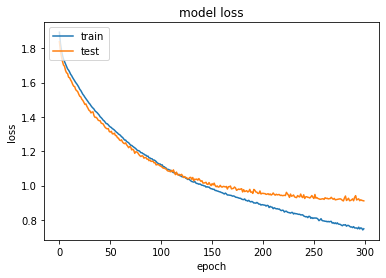

In [183]:
plt.plot(cnnhistory_mix_d.history['loss'])
plt.plot(cnnhistory_mix_d.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

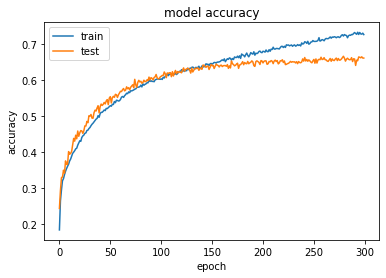

In [184]:
plt.plot(cnnhistory_mix_d.history['accuracy'])
plt.plot(cnnhistory_mix_d.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)

In [203]:
 #NO evaluate loaded model on test data
model_mix_e.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score_mix_e = model_mix_e.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model_mix_e.metrics_names[1], score_mix_e[1]*100))

accuracy: 66.22%


In [192]:
preds_mix_e = model_mix_e.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

81/81 [==============================] - 1s 13ms/step


In [193]:
preds1_mix_e=preds_mix_e.argmax(axis=1)

In [194]:
abc_mix_e = preds1_mix_e.astype(int).flatten()

In [195]:
predictions_mix_e = (lb.inverse_transform((abc_mix_e)))

In [196]:
preddf_mix_e = pd.DataFrame({'predictedvalues': predictions_mix_e})
preddf_mix_e[:10]

,predictedvalues
0,fearful
1,fearful
2,happy
3,surprised
4,neutral
5,fearful
6,angry
7,fearful
8,happy
9,surprised


In [197]:
actual_mix_e=y_test.argmax(axis=1)
abc123_mix_e = actual_mix_e.astype(int).flatten()
actualvalues_mix_e = (lb.inverse_transform((abc123_mix_e)))

In [198]:
actualdf_mix_e = pd.DataFrame({'actualvalues': actualvalues_mix_e})
actualdf_mix_e[:10]

,actualvalues
0,fearful
1,fearful
2,happy
3,surprised
4,neutral
5,fearful
6,angry
7,fearful
8,disgust
9,surprised


In [199]:
finaldf_mix_e = actualdf_mix_e.join(preddf_mix_e)

In [200]:
finaldf_mix_e

,actualvalues,predictedvalues
0,fearful,fearful
1,fearful,fearful
2,happy,happy
3,surprised,surprised
4,neutral,neutral
...,...,...
2579,sad,fearful
2580,neutral,disgust
2581,fearful,fearful
2582,angry,angry


In [286]:
finaldf_mix_e.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,460
disgust,368
fearful,407
happy,444
neutral,370
sad,410
surprised,125


In [285]:
finaldf_mix_e.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,449
disgust,328
fearful,376
happy,448
neutral,385
sad,465
surprised,133


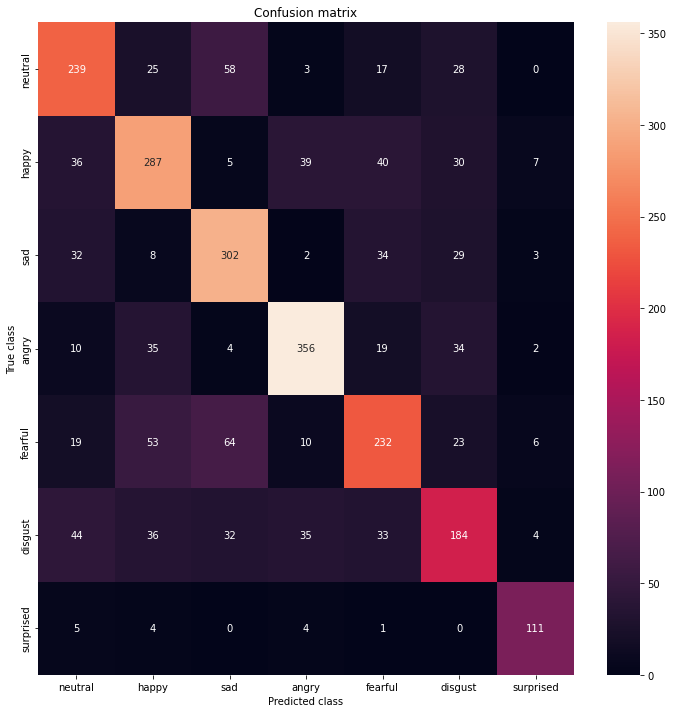

              precision    recall  f1-score   support

       angry       0.79      0.77      0.78       460
     disgust       0.56      0.50      0.53       368
     fearful       0.62      0.57      0.59       407
       happy       0.64      0.65      0.64       444
     neutral       0.62      0.65      0.63       370
         sad       0.65      0.74      0.69       410
   surprised       0.83      0.89      0.86       125

    accuracy                           0.66      2584
   macro avg       0.67      0.68      0.68      2584
weighted avg       0.66      0.66      0.66      2584



In [289]:
mostrar_resultados(actualdf_mix_e, preddf_mix_e)

In [216]:
model_mix_fb = Sequential()

model_mix_fb.add(Conv1D(128, 5,padding='same', input_shape=(52,1)))
model_mix_fb.add(Activation('relu'))
model_mix_fb.add(Conv1D(256, 5,padding='same'))
model_mix_fb.add(Activation('relu'))
model_mix_fb.add(Dropout(0.1))
model_mix_fb.add(Conv1D(256, 5,padding='same',))
model_mix_fb.add(Activation('relu'))
model_mix_fb.add(Conv1D(256, 5,padding='same',))
model_mix_fb.add(Activation('relu'))
model_mix_fb.add(MaxPooling1D(pool_size=(8)))
model_mix_fb.add(LSTM(128))
model_mix_fb.add(Activation('relu'))
model_mix_fb.add(Flatten())
model_mix_fb.add(Dense(7))
model_mix_fb.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

In [190]:
model_mix_fb.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [191]:
cnnhistory_mix_fb=model_mix_fb.fit(x_traincnn, y_train, batch_size=16, epochs=300, validation_data=(x_testcnn, y_test))

Epoch 1/300
639/639 [==============================] - 29s 45ms/step - loss: 1.8526 - accuracy: 0.2596 - val_loss: 1.7702 - val_accuracy: 0.3146
Epoch 2/300
639/639 [==============================] - 27s 42ms/step - loss: 1.7299 - accuracy: 0.3162 - val_loss: 1.6571 - val_accuracy: 0.3591
Epoch 3/300
639/639 [==============================] - 29s 45ms/step - loss: 1.6554 - accuracy: 0.3474 - val_loss: 1.6127 - val_accuracy: 0.3572
Epoch 4/300
639/639 [==============================] - 29s 45ms/step - loss: 1.6066 - accuracy: 0.3646 - val_loss: 1.5925 - val_accuracy: 0.3630
Epoch 5/300
639/639 [==============================] - 26s 41ms/step - loss: 1.5651 - accuracy: 0.3858 - val_loss: 1.5154 - val_accuracy: 0.4145
Epoch 6/300
639/639 [==============================] - 26s 41ms/step - loss: 1.5366 - accuracy: 0.3982 - val_loss: 1.4809 - val_accuracy: 0.4423
Epoch 7/300
639/639 [==============================] - 26s 41ms/step - loss: 1.5114 - accuracy: 0.4109 - val_loss: 1.4679 - val_ac

KeyboardInterrupt: 

In [205]:
plt.plot(cnnhistory_mix_f.history['loss'])
plt.plot(cnnhistory_mix_f.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'cnnhistory_mix_f' is not defined

## Bidireccional

In [217]:
model_bi = Sequential()

model_bi.add(Conv1D(128, 5,padding='same', input_shape=(52,1)))
model_bi.add(Activation('relu'))
model_bi.add(Conv1D(256, 5,padding='same'))
model_bi.add(Activation('relu'))
model_bi.add(Dropout(0.1))
model_bi.add(Conv1D(256, 5,padding='same',))
model_bi.add(Activation('relu'))
model_bi.add(MaxPooling1D(pool_size=(8)))

model_bi.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bi.add(Bidirectional(LSTM(64)))
model_bi.add(Activation('relu'))
model_bi.add(Flatten())
model_bi.add(Dense(7))
model_bi.add(Activation('softmax'))


In [292]:
model_bi.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 52, 128)           768       
_________________________________________________________________
activation_132 (Activation)  (None, 52, 128)           0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 52, 256)           164096    
_________________________________________________________________
activation_133 (Activation)  (None, 52, 256)           0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 52, 256)           0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 52, 256)           327936    
_________________________________________________________________
activation_134 (Activation)  (None, 52, 256)         

In [219]:
model_bi.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [220]:
cnnhistory_bi=model_bi.fit(x_traincnn, y_train, batch_size=16, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
639/639 [==============================] - 27s 42ms/step - loss: 1.8734 - accuracy: 0.2442 - val_loss: 1.8115 - val_accuracy: 0.3216
Epoch 2/150
639/639 [==============================] - 25s 39ms/step - loss: 1.7848 - accuracy: 0.2983 - val_loss: 1.7204 - val_accuracy: 0.3305
Epoch 3/150
639/639 [==============================] - 25s 40ms/step - loss: 1.7206 - accuracy: 0.3121 - val_loss: 1.6658 - val_accuracy: 0.3340
Epoch 4/150
639/639 [==============================] - 25s 39ms/step - loss: 1.6785 - accuracy: 0.3266 - val_loss: 1.6343 - val_accuracy: 0.3371
Epoch 5/150
639/639 [==============================] - 26s 41ms/step - loss: 1.6511 - accuracy: 0.3388 - val_loss: 1.5958 - val_accuracy: 0.3615
Epoch 6/150
639/639 [==============================] - 27s 43ms/step - loss: 1.6193 - accuracy: 0.3489 - val_loss: 1.5745 - val_accuracy: 0.3696
Epoch 7/150
639/639 [==============================] - 26s 41ms/step - loss: 1.5979 - accuracy: 0.3621 - val_loss: 1.5469 - val_ac

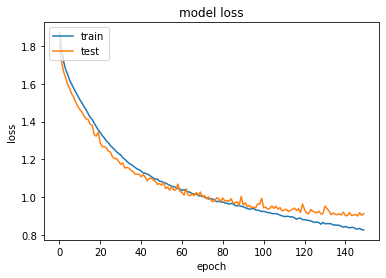

In [235]:
plt.plot(cnnhistory_bi.history['loss'])
plt.plot(cnnhistory_bi.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

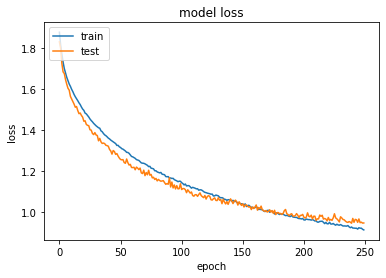

In [294]:
plt.plot(cnnhistory_bi2.history['loss'])
plt.plot(cnnhistory_bi2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

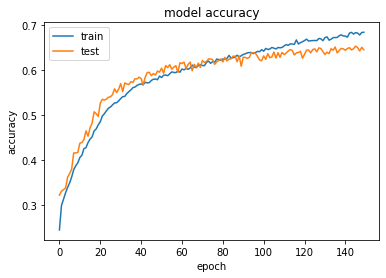

In [236]:
plt.plot(cnnhistory_bi.history['accuracy'])
plt.plot(cnnhistory_bi.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

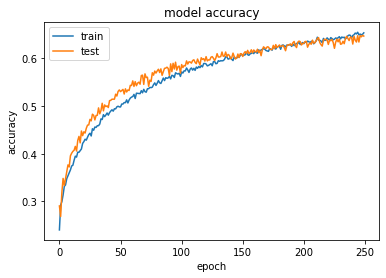

In [295]:
plt.plot(cnnhistory_bi2.history['accuracy'])
plt.plot(cnnhistory_bi2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [297]:
 #NO evaluate loaded model on test data
#model_bi.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score_bi2 = model_bi2.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model_bi.metrics_names[1], score_bi2[1]*100))

accuracy: 64.59%


In [222]:
preds_bi = model_bi.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

81/81 [==============================] - 1s 14ms/step


In [298]:
preds_bi2 = model_bi2.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

81/81 [==============================] - 1s 17ms/step


In [223]:
preds1_bi=preds_bi.argmax(axis=1)

In [299]:
preds1_bi2=preds_bi2.argmax(axis=1)

In [224]:
abc_bi = preds1_bi.astype(int).flatten()

In [300]:
abc_bi2 = preds1_bi2.astype(int).flatten()

In [225]:
predictions_bi = (lb.inverse_transform((abc_bi))) #y_test

In [301]:
predictions_bi2 = (lb.inverse_transform((abc_bi2))) #y_test

In [226]:
preddf_bi = pd.DataFrame({'predictedvalues': predictions_bi})
preddf_bi[:10]

,predictedvalues
0,fearful
1,fearful
2,fearful
3,surprised
4,neutral
5,fearful
6,angry
7,fearful
8,neutral
9,surprised


In [303]:
preddf_bi2 = pd.DataFrame({'predictedvalues': predictions_bi2})

In [227]:
actual_bi=y_test.argmax(axis=1)
abc123_bi = actual_bi.astype(int).flatten()
actualvalues_bi = (lb.inverse_transform((abc123_bi)))

In [304]:
actual_bi2=y_test.argmax(axis=1)
abc123_bi2 = actual_bi2.astype(int).flatten()
actualvalues_bi2 = (lb.inverse_transform((abc123_bi2)))
actualdf_bi2 = pd.DataFrame({'actualvalues': actualvalues_bi2})

In [228]:
actualdf_bi = pd.DataFrame({'actualvalues': actualvalues_bi})
actualdf_bi[:10]

,actualvalues
0,fearful
1,fearful
2,happy
3,surprised
4,neutral
5,fearful
6,angry
7,fearful
8,disgust
9,surprised


In [229]:
finaldf_bi = actualdf_bi.join(preddf_bi)

In [306]:
finaldf_bi.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,460
disgust,368
fearful,407
happy,444
neutral,370
sad,410
surprised,125


In [308]:
finaldf_bi.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,416
disgust,299
fearful,397
happy,354
neutral,430
sad,558
surprised,130


In [309]:
finaldf_bi2.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,456
disgust,399
fearful,312
happy,369
neutral,365
sad,533
surprised,150


In [305]:
finaldf_bi2 = actualdf_bi2.join(preddf_bi2)

In [234]:
#print("AUC score 2", roc_auc_score(actualdf_bi, preddf_bi))

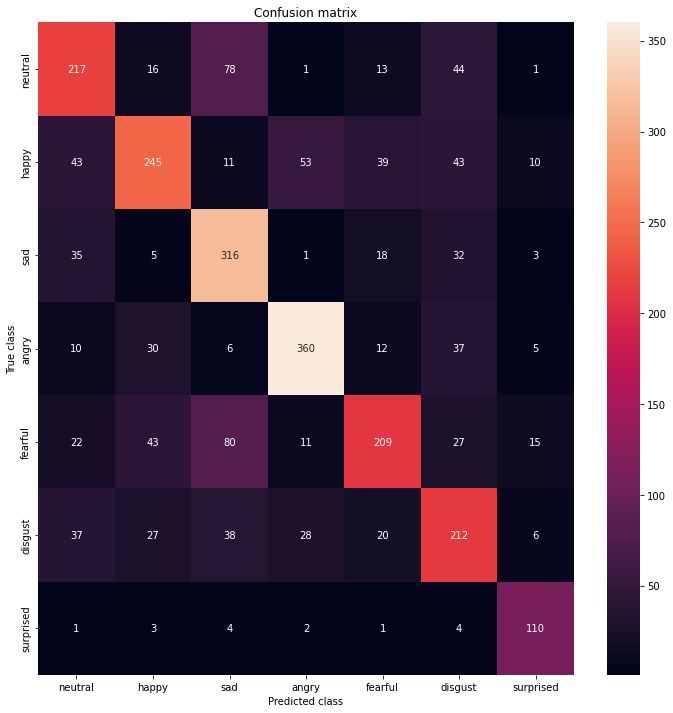

              precision    recall  f1-score   support

       angry       0.79      0.78      0.79       460
     disgust       0.53      0.58      0.55       368
     fearful       0.67      0.51      0.58       407
       happy       0.66      0.55      0.60       444
     neutral       0.59      0.59      0.59       370
         sad       0.59      0.77      0.67       410
   surprised       0.73      0.88      0.80       125

    accuracy                           0.65      2584
   macro avg       0.65      0.67      0.65      2584
weighted avg       0.65      0.65      0.64      2584



In [310]:
mostrar_resultados(actualvalues_bi2, preddf_bi2)

## Solo convolucionales

In [ ]:
#4 CNN? esto lo hemos testado??

In [314]:
model_4cnn = Sequential()

model_4cnn.add(Conv1D(256, 5,padding='same',input_shape=(52,1)))
model_4cnn.add(Activation('relu'))
model_4cnn.add(Conv1D(128, 5,padding='same'))
model_4cnn.add(Activation('relu'))
model_4cnn.add(Dropout(0.1))
model_4cnn.add(MaxPooling1D(pool_size=(8)))
model_4cnn.add(Conv1D(128, 5,padding='same',))
model_4cnn.add(Activation('relu'))
model_4cnn.add(Conv1D(128, 5,padding='same',))
model_4cnn.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
model_4cnn.add(Activation('relu'))
model_4cnn.add(Flatten())
model_4cnn.add(Dense(7))
model_4cnn.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

In [315]:
model_4cnn.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [242]:
cnnhistory_cnn=model_cnn.fit(x_traincnn, y_train, batch_size=16, epochs=250, validation_data=(x_testcnn, y_test))

Epoch 1/150
103/103 [==============================] - 7s 68ms/step - loss: 2.3037 - accuracy: 0.1876 - val_loss: 1.7193 - val_accuracy: 0.3181
Epoch 2/150
103/103 [==============================] - 7s 68ms/step - loss: 1.8850 - accuracy: 0.2556 - val_loss: 1.6386 - val_accuracy: 0.3344
Epoch 3/150
103/103 [==============================] - 9s 84ms/step - loss: 1.7672 - accuracy: 0.2900 - val_loss: 1.5898 - val_accuracy: 0.3630
Epoch 4/150
103/103 [==============================] - 8s 76ms/step - loss: 1.7082 - accuracy: 0.3089 - val_loss: 1.5677 - val_accuracy: 0.3688
Epoch 5/150
103/103 [==============================] - 8s 76ms/step - loss: 1.6696 - accuracy: 0.3273 - val_loss: 1.5464 - val_accuracy: 0.3827
Epoch 6/150
103/103 [==============================] - 8s 80ms/step - loss: 1.6408 - accuracy: 0.3367 - val_loss: 1.5366 - val_accuracy: 0.3882
Epoch 7/150
103/103 [==============================] - 8s 76ms/step - loss: 1.6048 - accuracy: 0.3559 - val_loss: 1.5084 - val_accuracy:

In [316]:
cnnhistory_4cnn=model_4cnn.fit(x_traincnn, y_train, batch_size=16, epochs=250, validation_data=(x_testcnn, y_test))

Epoch 1/250
639/639 [==============================] - 11s 18ms/step - loss: 1.8340 - accuracy: 0.2990 - val_loss: 1.5660 - val_accuracy: 0.3719
Epoch 2/250
639/639 [==============================] - 12s 18ms/step - loss: 1.6056 - accuracy: 0.3547 - val_loss: 1.5116 - val_accuracy: 0.4002
Epoch 3/250
639/639 [==============================] - 11s 17ms/step - loss: 1.5484 - accuracy: 0.3867 - val_loss: 1.4704 - val_accuracy: 0.4342
Epoch 4/250
639/639 [==============================] - 12s 19ms/step - loss: 1.4991 - accuracy: 0.4090 - val_loss: 1.4347 - val_accuracy: 0.4497
Epoch 5/250
639/639 [==============================] - 10s 16ms/step - loss: 1.4680 - accuracy: 0.4229 - val_loss: 1.3992 - val_accuracy: 0.4590
Epoch 6/250
639/639 [==============================] - 11s 17ms/step - loss: 1.4289 - accuracy: 0.4497 - val_loss: 1.3794 - val_accuracy: 0.4826
Epoch 7/250
639/639 [==============================] - 11s 18ms/step - loss: 1.4083 - accuracy: 0.4492 - val_loss: 1.3378 - val_ac

In [313]:
model_4cnn.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_128 (Conv1D)          (None, 52, 256)           1536      
_________________________________________________________________
activation_202 (Activation)  (None, 52, 256)           0         
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 52, 128)           163968    
_________________________________________________________________
activation_203 (Activation)  (None, 52, 128)           0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 52, 128)           0         
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 6, 128)            0         
_________________________________________________________________
conv1d_130 (Conv1D)          (None, 6, 128)          

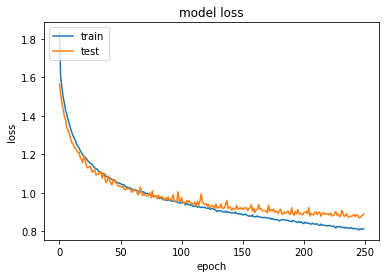

In [317]:
plt.plot(cnnhistory_4cnn.history['loss'])
plt.plot(cnnhistory_4cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

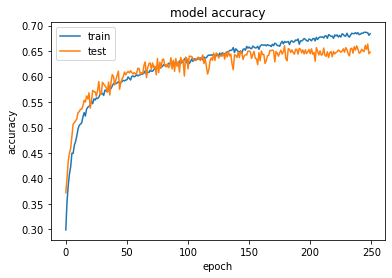

In [332]:
plt.plot(cnnhistory_4cnn.history['accuracy'])
plt.plot(cnnhistory_4cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [319]:
score_4cnn = model_4cnn.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (model_4cnn.metrics_names[1], score_4cnn[1]*100))

accuracy: 64.78%


In [320]:
preds_4cnn = model_4cnn.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

81/81 [==============================] - 0s 5ms/step


In [321]:
preds1_4cnn=preds_4cnn.argmax(axis=1)

In [322]:
abc_4cnn = preds1_4cnn.astype(int).flatten()

In [323]:
predictions_4cnn = (lb.inverse_transform((abc_4cnn)))

In [324]:
preddf_4cnn = pd.DataFrame({'predictedvalues': predictions_4cnn})
preddf_4cnn[:10]

,predictedvalues
0,fearful
1,happy
2,happy
3,surprised
4,neutral
5,happy
6,angry
7,fearful
8,neutral
9,surprised


In [325]:
actual_4cnn=y_test.argmax(axis=1)
abc123_4cnn = actual_4cnn.astype(int).flatten()
actualvalues_4cnn = (lb.inverse_transform((abc123_4cnn)))

In [326]:
actualdf_4cnn = pd.DataFrame({'actualvalues': actualvalues_4cnn})
actualdf_4cnn[:10]

,actualvalues
0,fearful
1,fearful
2,happy
3,surprised
4,neutral
5,fearful
6,angry
7,fearful
8,disgust
9,surprised


In [327]:
finaldf_4cnn = actualdf_4cnn.join(preddf_4cnn)

In [328]:
finaldf_4cnn

,actualvalues,predictedvalues
0,fearful,fearful
1,fearful,happy
2,happy,happy
3,surprised,surprised
4,neutral,neutral
...,...,...
2579,sad,neutral
2580,neutral,disgust
2581,fearful,fearful
2582,angry,angry


In [329]:
finaldf_4cnn.groupby('actualvalues').count()

,predictedvalues
actualvalues,
angry,460
disgust,368
fearful,407
happy,444
neutral,370
sad,410
surprised,125


In [330]:
finaldf_4cnn.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
angry,506
disgust,383
fearful,251
happy,500
neutral,428
sad,378
surprised,138


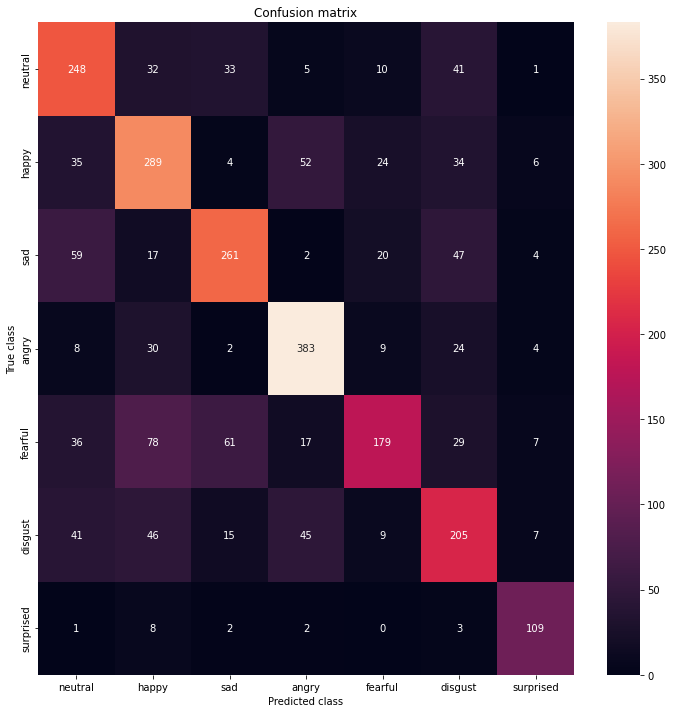

              precision    recall  f1-score   support

       angry       0.76      0.83      0.79       460
     disgust       0.54      0.56      0.55       368
     fearful       0.71      0.44      0.54       407
       happy       0.58      0.65      0.61       444
     neutral       0.58      0.67      0.62       370
         sad       0.69      0.64      0.66       410
   surprised       0.79      0.87      0.83       125

    accuracy                           0.65      2584
   macro avg       0.66      0.67      0.66      2584
weighted avg       0.65      0.65      0.64      2584



In [331]:
mostrar_resultados(actualvalues_4cnn, preddf_4cnn)

# PRUEBAS INCLUIR TFM

## 2. Bi con batch 100 y 200 de epocas

In [259]:
model_bi2 = Sequential()

model_bi2.add(Conv1D(128, 5,padding='same', input_shape=(52,1)))
model_bi2.add(Activation('relu'))
model_bi2.add(Conv1D(256, 5,padding='same'))
model_bi2.add(Activation('relu'))
model_bi2.add(Dropout(0.1))
model_bi2.add(Conv1D(256, 5,padding='same',))
model_bi2.add(Activation('relu'))
model_bi2.add(MaxPooling1D(pool_size=(8)))

model_bi2.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bi2.add(Bidirectional(LSTM(64)))
model_bi2.add(Activation('relu'))
model_bi2.add(Flatten())
model_bi2.add(Dense(7))
model_bi2.add(Activation('softmax'))

In [293]:
model_bi2.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_118 (Conv1D)          (None, 52, 128)           768       
_________________________________________________________________
activation_187 (Activation)  (None, 52, 128)           0         
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 52, 256)           164096    
_________________________________________________________________
activation_188 (Activation)  (None, 52, 256)           0         
_________________________________________________________________
dropout_49 (Dropout)         (None, 52, 256)           0         
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 52, 256)           327936    
_________________________________________________________________
activation_189 (Activation)  (None, 52, 256)         

In [260]:
model_bi2.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [261]:
cnnhistory_bi2=model_bi2.fit(x_traincnn, y_train, batch_size=100, epochs=250, validation_data=(x_testcnn, y_test))

Epoch 1/250
103/103 [==============================] - 20s 197ms/step - loss: 1.8762 - accuracy: 0.2405 - val_loss: 1.8294 - val_accuracy: 0.2906
Epoch 2/250
103/103 [==============================] - 20s 199ms/step - loss: 1.8124 - accuracy: 0.2928 - val_loss: 1.7979 - val_accuracy: 0.2686
Epoch 3/250
103/103 [==============================] - 20s 195ms/step - loss: 1.7689 - accuracy: 0.2995 - val_loss: 1.7244 - val_accuracy: 0.3189
Epoch 4/250
103/103 [==============================] - 20s 196ms/step - loss: 1.7305 - accuracy: 0.3136 - val_loss: 1.6832 - val_accuracy: 0.3483
Epoch 5/250
103/103 [==============================] - 19s 187ms/step - loss: 1.6992 - accuracy: 0.3316 - val_loss: 1.6749 - val_accuracy: 0.3336
Epoch 6/250
103/103 [==============================] - 20s 194ms/step - loss: 1.6779 - accuracy: 0.3347 - val_loss: 1.6456 - val_accuracy: 0.3475
Epoch 7/250
103/103 [==============================] - 19s 186ms/step - loss: 1.6567 - accuracy: 0.3477 - val_loss: 1.6229 -

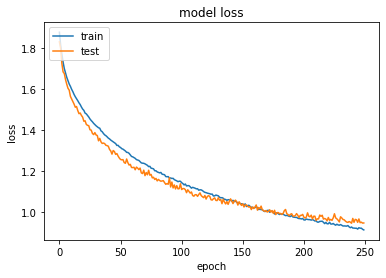

In [290]:
plt.plot(cnnhistory_bi2.history['loss'])
plt.plot(cnnhistory_bi2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

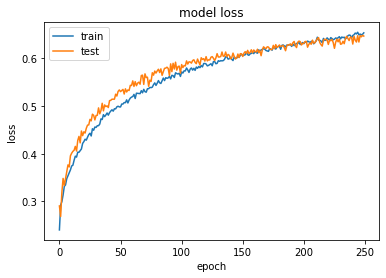

In [291]:
plt.plot(cnnhistory_bi2.history['accuracy'])
plt.plot(cnnhistory_bi2.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 2. Mixto con 100 y 200

In [ ]:
model_mix2 = Sequential()

model_mix2.add(Conv1D(128, 5,padding='same', input_shape=(52,1)))
model_mix2.add(Activation('relu'))
model_mix2.add(Conv1D(256, 5,padding='same'))
model_mix2.add(Activation('relu'))
model_mix2.add(Dropout(0.1))
model_mix2.add(Conv1D(256, 5,padding='same',))
model_mix2.add(Activation('relu'))
model_mix2.add(MaxPooling1D(pool_size=(8)))

model_mix2.add(Conv1D(128, 5,padding='same',))
model_mix2.add(Activation('relu'))

model_mix2.add(Dropout(0.2))
model_mix2.add(Conv1D(128, 5,padding='same',))
model_mix2.add(Activation('relu'))

model_mix2.add(MaxPooling1D(pool_size=(8)))
model_mix2.add(LSTM(32))
model_mix2.add(Activation('relu'))
model_mix2.add(Flatten())
model_mix2.add(Dense(7))
model_mix2.add(Activation('softmax'))
opt = keras.optimizers.Adam(lr=0.00001, decay=1e-6)

## 3. 